# Agra loan Pricer

In this document I will attempt to do an analytical pricing of loans against accounts in agra. We will take simplified cases and then attempt to extend  
The first will be lending against a simple Aave account

The net value of a loan on a DeFi Protocol can be expressed as:

$$
\sum_{i=1}^{n} a_i \cdot x_i \cdot e^{r_i \cdot t_i} - \sum_{j=1}^{m} a_j \cdot x_j \cdot e^{r_j \cdot t_j}
$$


Where all $x_i$ represent asset supplied, all $x_i$, represent assets lent.  
All $a_i$ represent the amount and $r_i$ and $t_i$ represent the borrow/lending rate and time they have been borrowed/lent for.  

For many loan protocols it is not the Net value but the quotient of their values that defines if the protocol is insolvent or not. So for something like Aave we know that it is solvent so long as 

$$
\frac{\sum_{i=1}^{n} a_i \cdot x_i \cdot e^{r_i \cdot t_i} \cdot l_i}{\sum_{j=1}^{m} a_j \cdot x_j \cdot e^{r_j \cdot t_j}} > 1
$$

Where $l_i$ is the liquidation threshold for collateral x (e.g 0.83 for eth on Aave mainnet)

But as soon as we hit the point where that is not true we have a liquidation 

If we were to provide a loan against an account which holds a position like this, in the case that we were to be liquidated we would receive 0 as there would be no incentive for the borrower to repay the loan

In the simplified case we will have a single asset borrowed against a single deposited. This is also the case where you loop though a lending protocol to get leverage

In this case the value of net value of the loan can be expressed as 
$$ a \cdot x  \cdot e^{r_1 \cdot t} - b \cdot y  \cdot e^{r_2 \cdot t} $$
And thus the liquidation threshold can be defined as
$$
\frac{a \cdot x  \cdot e^{r_1 \cdot t} \cdot l}{ b \cdot y  \cdot e^{r_2 \cdot t}} > 1 \rightarrow  l > \frac{ b \cdot y}{a \cdot x}e^{(r_2 - r_1) \cdot t}
$$

In [32]:
from math import exp
import matplotlib.pyplot as plt
import numpy as np

### Feel free to play with values

In [33]:
eth_supplied = 300
usc_borrowed = 300_000

rate_usdc = 0.05
rate_eth = 0.02

liquidation_threshold = 0.83

_time = 0.025  ## This is in years

In [34]:

def is_liquidatable(supplied_price: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> bool:
    return liquidation_threshold < (borrowed_price * borrowed_amount) / (supplied_price * supplied_amount) * exp((rate_borrowed - rate_supplied) * _time)

def account_value(supplied_price: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    if is_liquidatable(supplied_price, supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold):
        return 0
    return (supplied_price * supplied_amount) * exp(rate_supplied * _time) - (borrowed_price * borrowed_amount) * exp(rate_supplied * _time)

def liquidation_price(supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    return ((borrowed_amount * borrowed_price) / (supplied_amount * liquidation_threshold)) * exp((rate_borrowed - rate_supplied) * _time)

def buffer(supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float, liquidation_threshold: float) -> float:
    liq_price = liquidation_price(supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold)
    return account_value(liq_price + 0.00001, supplied_amount, borrowed_price, borrowed_amount, rate_supplied, rate_borrowed, _time, liquidation_threshold)


value = [account_value(i, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) for i in range(1, 4000)]

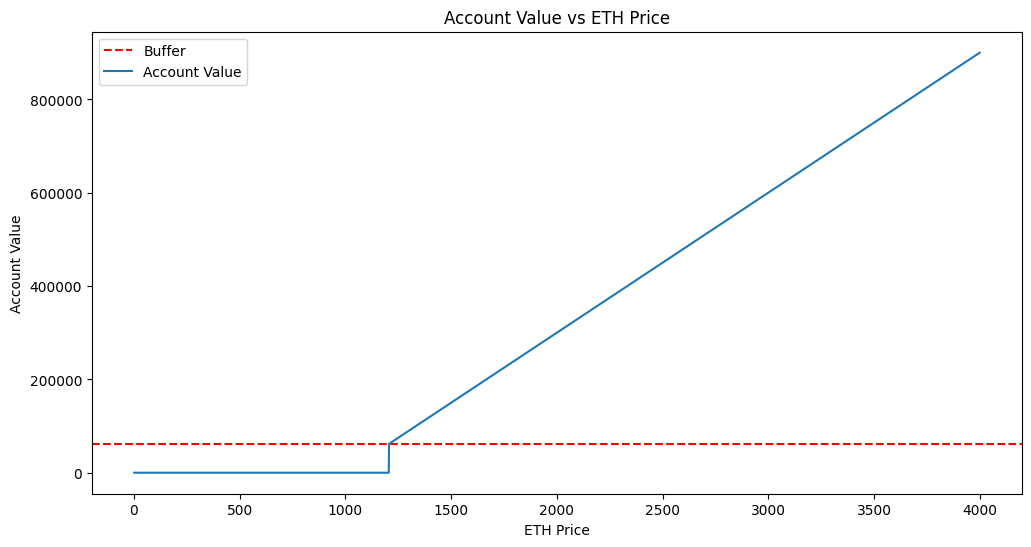

In [35]:
plt.figure(figsize=(12, 6))

buffer_account_value = buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold)

plt.axhline(y=buffer_account_value, color='r', linestyle='--', label='Buffer')

plt.plot(range(1, 4000), value, label='Account Value')
plt.ylabel('Account Value')
plt.xlabel('ETH Price')
plt.title('Account Value vs ETH Price')


# Add a legend to display the labels
plt.legend()

Now say you take out a loan against this the borrower will only pay you back if the value of the account is greater than the value of the loan

In [36]:
loan_amount = 50_000

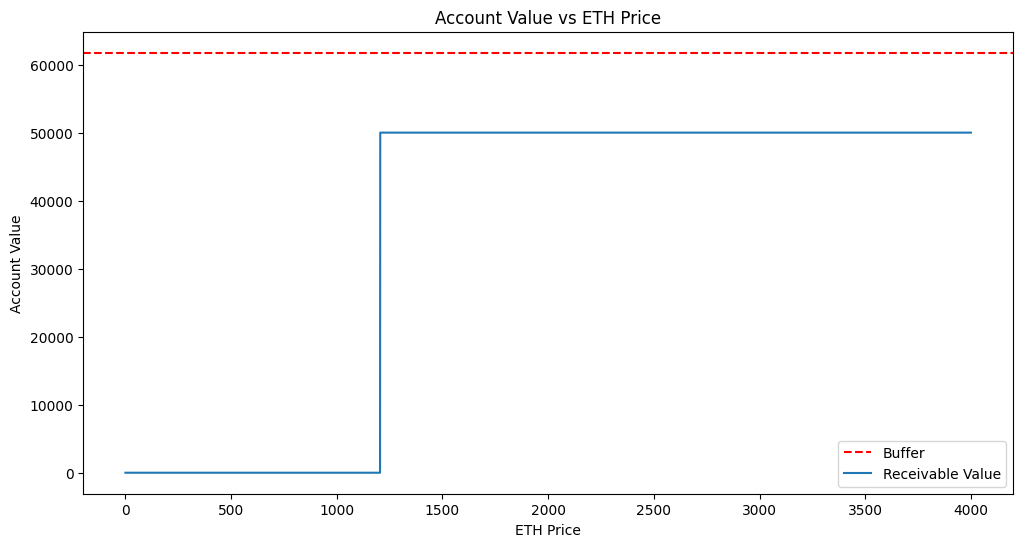

In [37]:
value = [min(account_value(i, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold), loan_amount) for i in range(1, 4000)]

plt.figure(figsize=(12, 6))

plt.axhline(y=buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) , color='r', linestyle='--', label='Buffer')

plt.plot(range(1, 4000), value, label='Receivable Value')
plt.ylabel('Account Value')
plt.xlabel('ETH Price')
plt.title('Account Value vs ETH Price')


# Add a legend to display the labels
plt.legend()

We can see that in the range between the liquidation point and the point at which the value of the account equals the amount loaned we move up steadily until we hit the cap.  
This is exactly being short a put spread between these 2 values

In [38]:
def indifference_point(net_value: float, supplied_amount: float, borrowed_price: float, borrowed_amount: float, rate_supplied: float, rate_borrowed: float, _time: float)  -> float:
    return (net_value + borrowed_amount * borrowed_price * exp(rate_borrowed * _time)) / (supplied_amount * exp(rate_supplied * _time))

In [39]:
liq_point_example = liquidation_price( eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold)
indifference_point_example =  indifference_point( loan_amount, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time)

In [40]:
def short_put_spread(size: float, lower: float, upper: float, price: float) -> float:
    return size * (max(0, lower - price) - max(0, upper - price))

short_put_spreads = [short_put_spread( eth_supplied, liq_point_example, indifference_point_example, i) for i in range(1, 4000)]

In [41]:
position_payout = [spr + loan_amount  for spr in short_put_spreads]

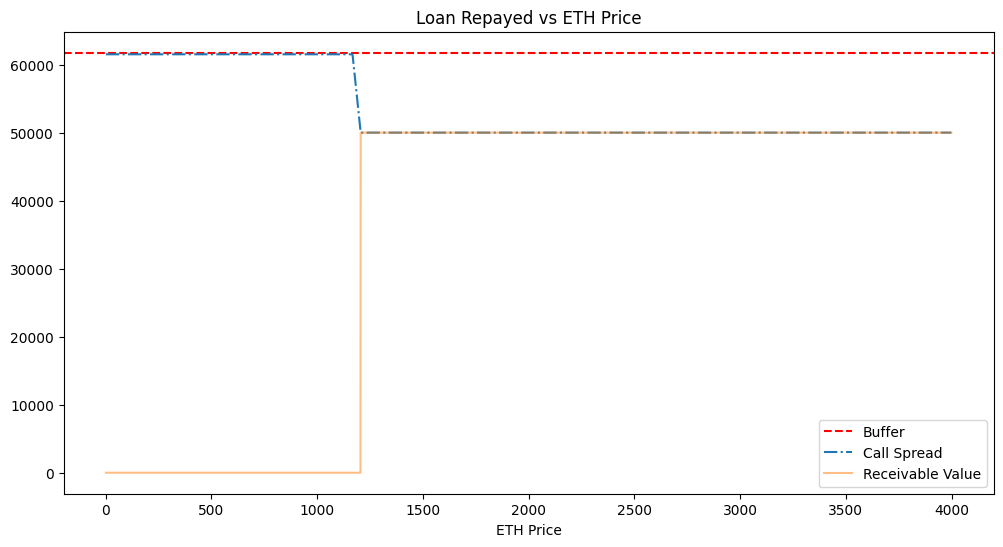

In [42]:
plt.figure(figsize=(12, 6))

plt.axhline(y=buffer(eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold) , color='r', linestyle='--', label='Buffer')


plt.plot(range(1, 4000), position_payout, label='Call Spread', alpha=1, linestyle='dashdot')
plt.plot(range(1, 4000), value, label='Receivable Value', alpha=0.5)
plt.xlabel('ETH Price')
plt.title('Loan Repayed vs ETH Price')


# Add a legend to display the labels
plt.legend()

The issue with replicating entirely with put spreads is that we need the payoff to be dependent on if the asset ever reaches the lower liquidation point. At that point we dont need the option any more. We need a one touch option (Also called an american digital option).  
Thankfully for me after some time I have found pricing for these options here (https://people.maths.ox.ac.uk/howison/barriers.pdf) so we should be able to calculate a closed form solution

The combination of options that makes up this position is a down and out put option and an american binary put option

In [43]:
def down_and_out_put_value(price: float, strike: float, barrier: float, rate: float, time: float) -> float:
    if price < barrier:
        return 0
    return max(0, strike - price) * exp(-rate * time)

def american_binary_put(price: float, strike: float, size: float) -> float:
    if price < strike:
        return size
    return 0

In [44]:
down_and_out_return = [loan_amount - down_and_out_put_value(i,indifference_point_example, liq_point_example, rate_eth, _time) * eth_supplied for i in range(1, 4000)]

In [45]:
american_binary_put_return = [loan_amount - american_binary_put(i, liq_point_example, loan_amount) for i in range(1, 4000)]

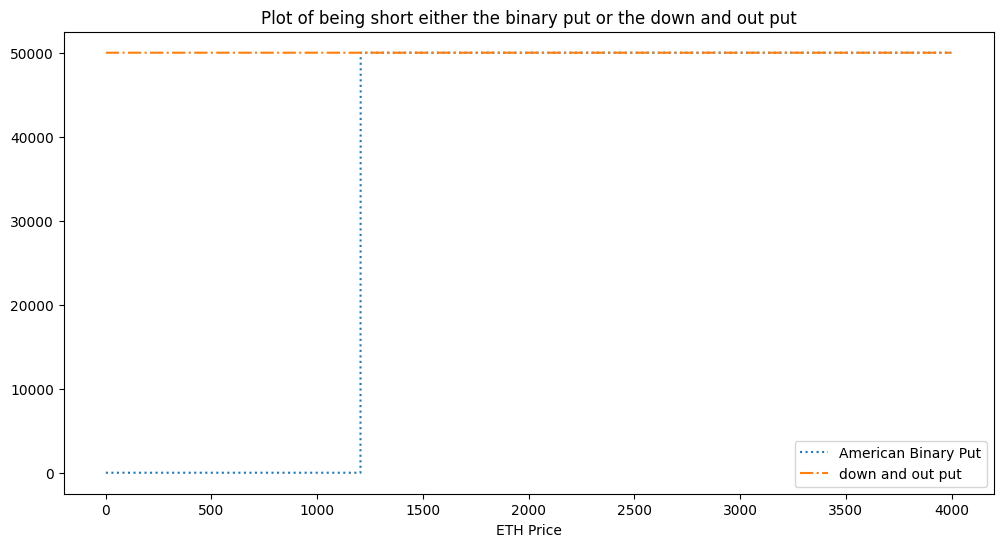

In [46]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, 4000), american_binary_put_return, label='American Binary Put', alpha=1, linestyle=':')
plt.plot(range(1, 4000), down_and_out_return, label='down and out put', alpha=1, linestyle='dashdot')
# plt.plot(range(1, 4000), value, label='Receivable Value', alpha=0.4)
plt.xlabel('ETH Price')
plt.title('Plot of being short either the binary put or the down and out put')


# Add a legend to display the labels
plt.legend()

Now we can show that being short both of these structures together gives the same payoff as the above example.

In [47]:
down_and_out_and_american_binary_put_return = [loan_amount - down_and_out_put_value(i,indifference_point_example, liq_point_example, rate_eth, _time) * eth_supplied - american_binary_put(i, liq_point_example, loan_amount) for i in range(1, 4000)]

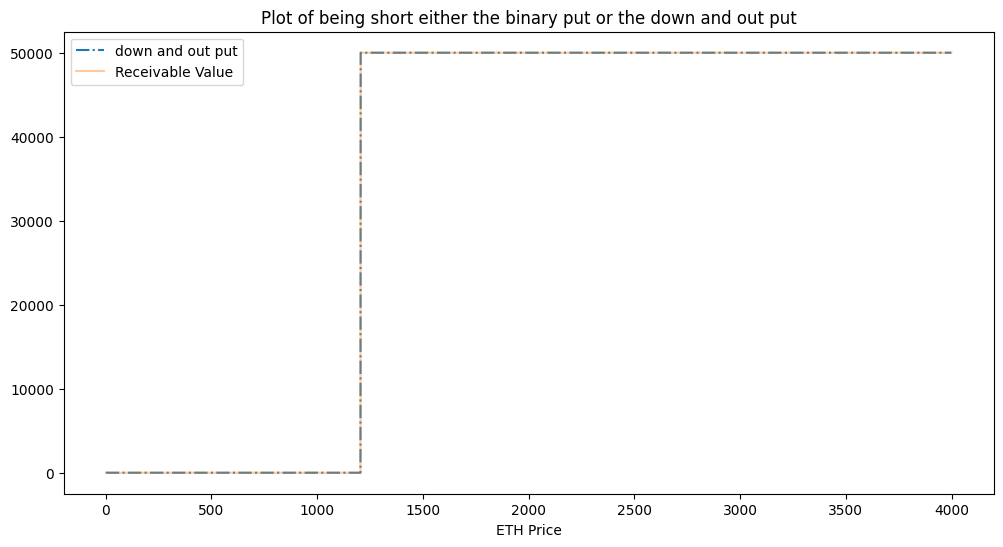

In [48]:
plt.figure(figsize=(12, 6))


plt.plot(range(1, 4000), down_and_out_and_american_binary_put_return, label='down and out put', alpha=1, linestyle='dashdot')
plt.plot(range(1, 4000), value, label='Receivable Value', alpha=0.4)
plt.xlabel('ETH Price')
plt.title('Plot of being short either the binary put or the down and out put')


# Add a legend to display the labels
plt.legend()

Ok now we will use the price these derivatives using the formulas from https://people.maths.ox.ac.uk/howison/barriers.pdf mentioned above

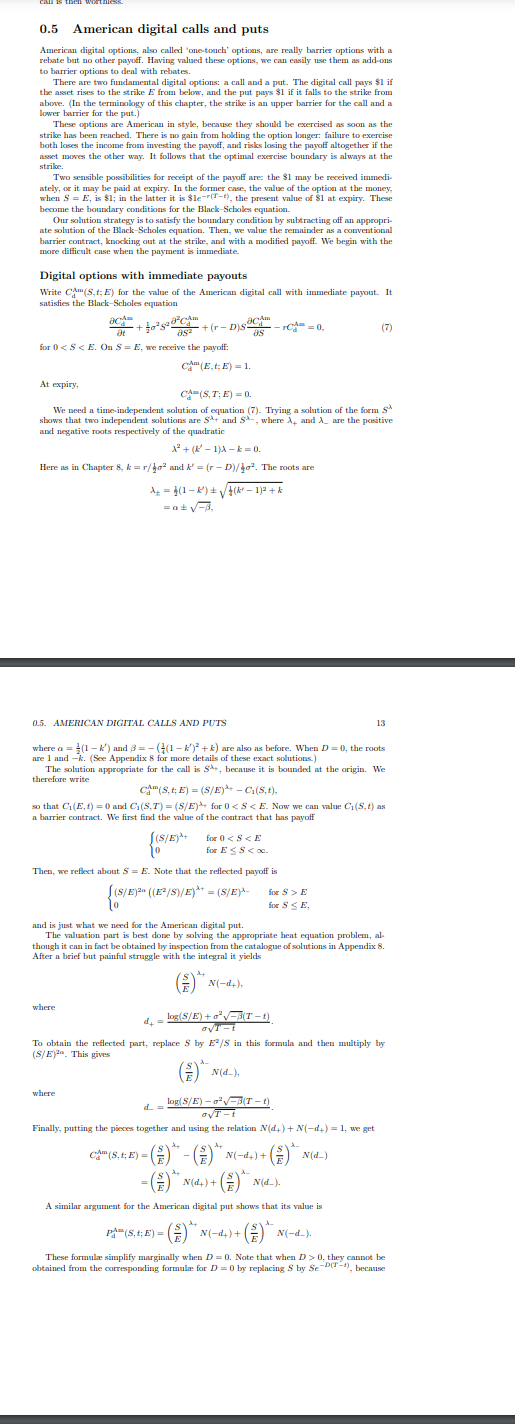

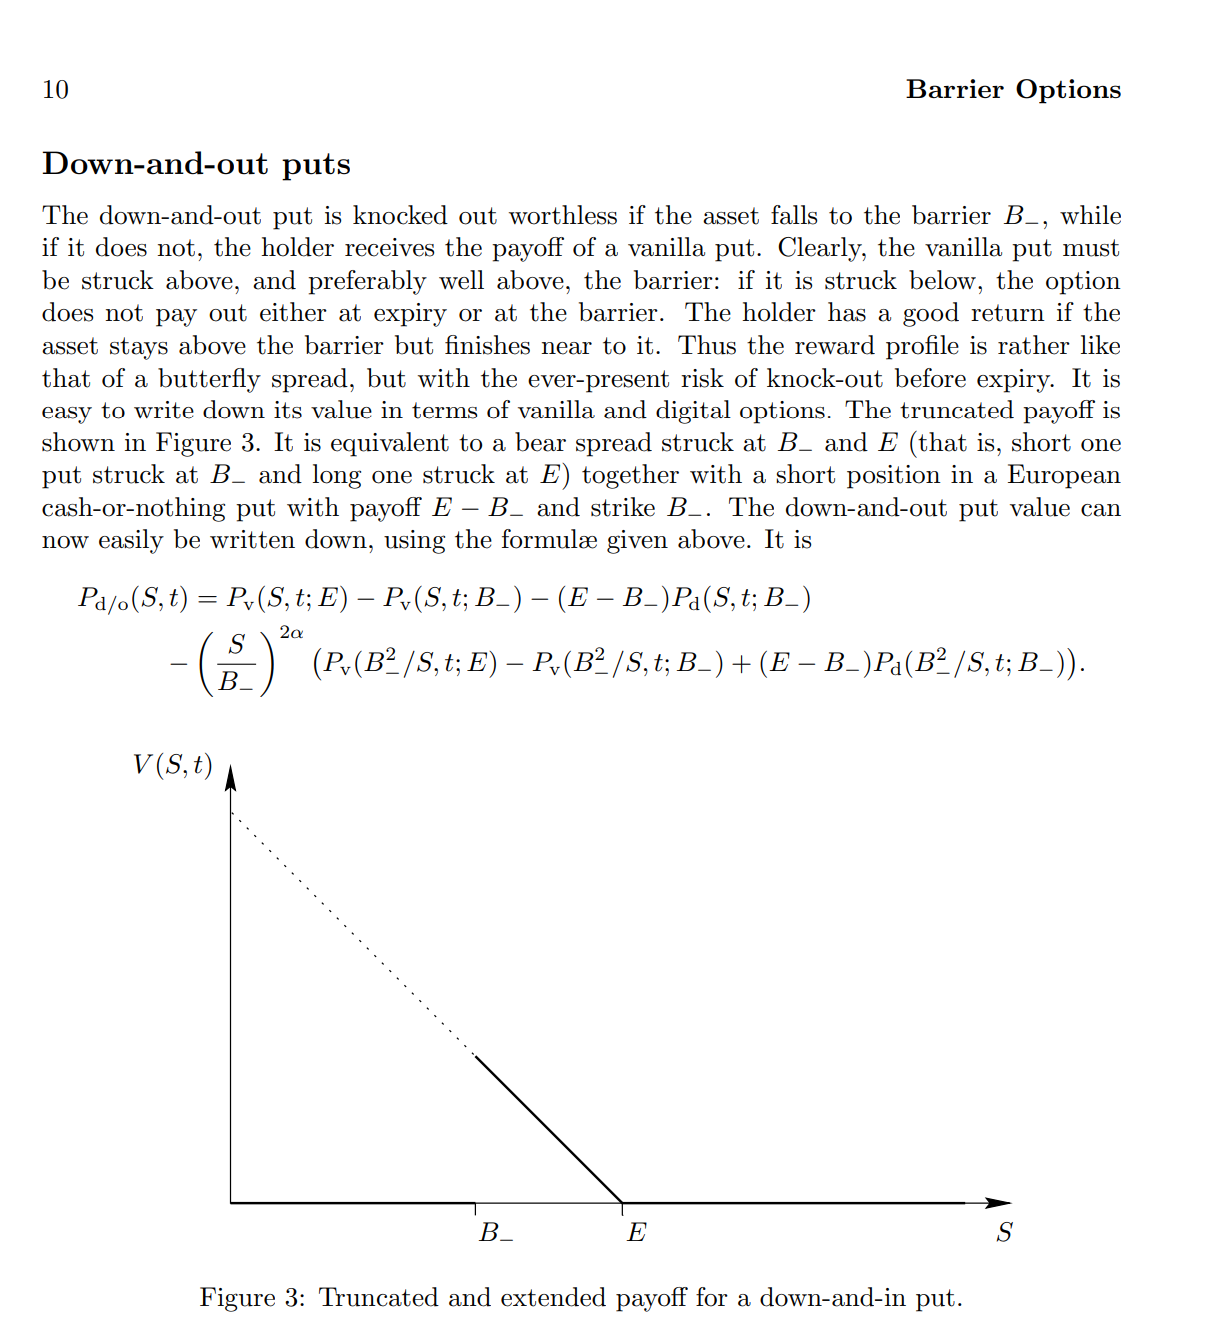

## Pricing methodology

I am using a fairly standard methodology using an arbitrage argument.

If we do not lend to the borrower. We will have $(X + O) \$$ at time 0, X Being the loan size and O being the price of the options to hedge. You will this have $(X + O)e^{rt}$ $ at time t  

If you do give the loan; then at time t you will receive the loaned amount X plus you will have the payment P, plus the interest on P as you receive it upfront. Thus you will have $X + Pe^{rt}\$$

$$
(X + O)e^{rt} = X + Pe^{rt} \rightarrow X + O = Xe^{-rt} + P \rightarrow O + X(1 - e^{-rt}) = P
$$

Or as a rate $R = \frac{O}{X} + (1 - e^{-rt})$  

We will also be using a similar metric to this for later generalizations when we will need to use Monte Carlo simulations to price these. It will be:
$$
Xe^{rt} =  \mathbb{E}[L] + Pe^{rt} \rightarrow P = X - \mathbb{E}[L]e^{-rt}
$$

Where $\mathbb{E}[L]$ is the expected value that we will be repayed as the lender at time t. Again as a rate this can be written as $ R = 1 - \frac{\mathbb{E}[L]}{X}e^{-rt}$

In [49]:
from optionPricing import  OptionPricer

pricer = OptionPricer()

Now we just need to set the time for the loan to maturity. I will also be setting a value for the volatility sigma and an eth price.  
I assume a flat smile here but in reality people usually use a smile so sigma would be a function of the strike.

In [50]:
vol = 0.7
eth_price = 2500
loan_time = 0.1
risk_free_rate = 0.05

In [51]:
def rate_to_apr(rate: float, time: float) -> float:
    return (1+rate) ** (1/time) - 1

In [52]:
def example_loan_cost(eth_price: float, point_of_indifference: float, liquidation_point: float, loan_time: float, risk_free_rate: float, vol: float, loan_size: float, eth_supplied) -> float:
    if liquidation_point > point_of_indifference:
        down_and_out_put = 0 ## If liquidation point is above the point of indifference, then the down and out put is worthless
    else:
        down_and_out_put = pricer.down_and_out_put(eth_price, point_of_indifference, liquidation_point, loan_time, risk_free_rate, vol)
    american_digital_put = pricer.american_digital_put(eth_price, liquidation_point, loan_time, risk_free_rate, vol)
    if down_and_out_put > pricer.vanilla_put(eth_price, point_of_indifference, loan_time, risk_free_rate, vol):
        raise ValueError("Down and out put is worth more than vanilla put")
    return american_digital_put * loan_size + down_and_out_put * eth_supplied

In [53]:
option_cost = example_loan_cost(eth_price, indifference_point_example, liq_point_example, loan_time, risk_free_rate, vol, loan_amount, eth_supplied)

loan_cost = option_cost + loan_amount * (1 - exp(-rate_usdc * loan_time))
loan_cost_as_rate = loan_cost / loan_amount

print(f'Option cost: {option_cost}$')
print(f"Loan cost: {loan_cost}$")
print(f"Loan cost as percentage: {loan_cost_as_rate * 100}%")
print(f"Loan apr: {rate_to_apr(loan_cost_as_rate, loan_time) * 100}%")

Option cost: 65.45103779159282$
Loan cost: 314.8270781574769$
Loan cost as percentage: 0.6296541563149538%
Loan apr: 6.477979408121692%


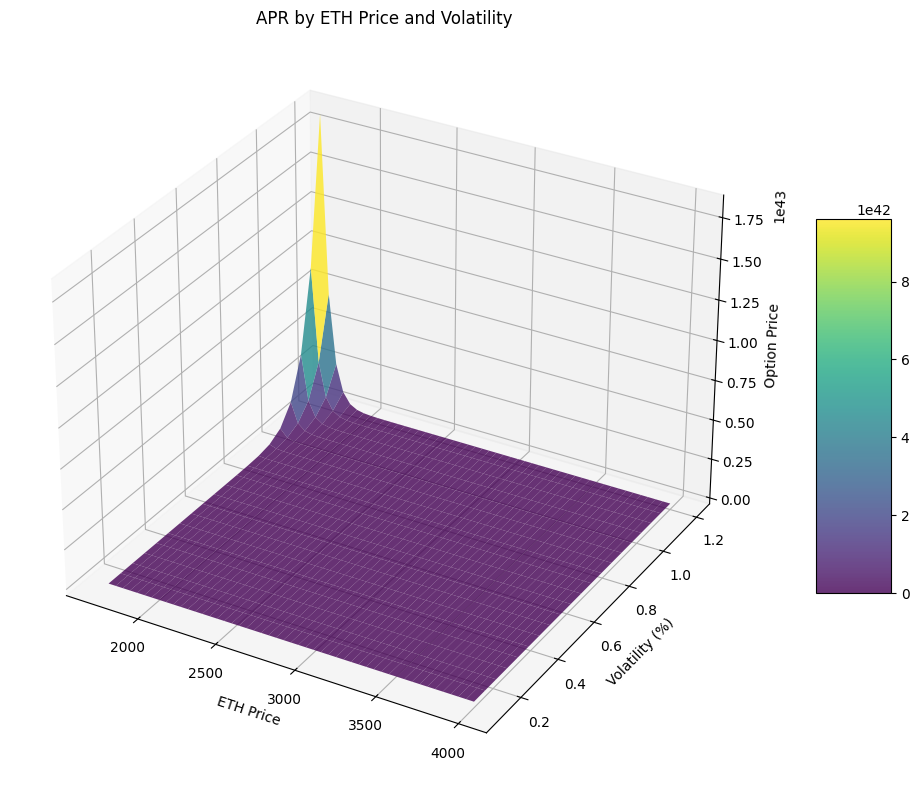

In [54]:
from mpl_toolkits.mplot3d import Axes3D

# Create data for the plot
x = np.linspace(1700, 4000, 50)  # ETH prices
y = np.linspace(.1, 1.20, 20) # Your volatility values
X, Y = np.meshgrid(x, y)  # Create 2D grid from x and y

# Calculate Z values (example: option price for each combination of price and volatility)
Z = np.zeros(X.shape)
for i in range(len(y)):
    for j in range(len(x)):
        # Example calculation - replace with your actual function
        Z[i, j] = rate_to_apr(example_loan_cost(x[j], indifference_point_example, liq_point_example, loan_time, risk_free_rate, y[i], loan_amount, eth_supplied), loan_time)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf =  ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels
ax.set_xlabel('ETH Price')
ax.set_ylabel('Volatility (%)')
ax.set_zlabel('Option Price')
ax.set_title('APR by ETH Price and Volatility')

plt.tight_layout()
plt.show()

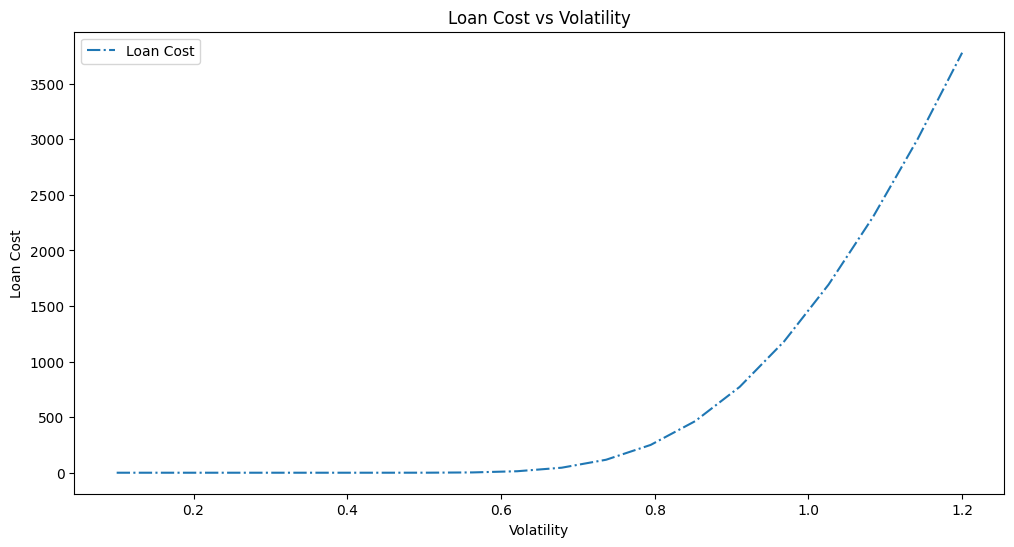

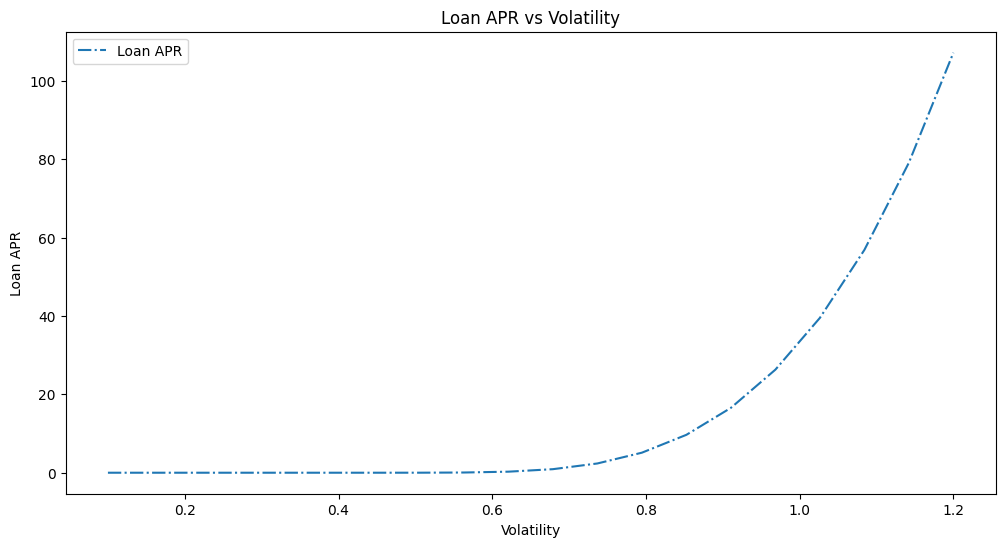

In [55]:
eth_price = 2500
values = [example_loan_cost(eth_price, indifference_point_example, liq_point_example, loan_time, risk_free_rate, i, loan_amount, eth_supplied) for i in y]
values_2 = [rate_to_apr(_val/loan_amount, loan_time) * 100 for _val in values]


plt.figure(figsize=(12, 6))
plt.plot(y, values, label='Loan Cost', alpha=1, linestyle='dashdot')
plt.xlabel('Volatility')
plt.ylabel('Loan Cost')
plt.title('Loan Cost vs Volatility')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(y, values_2, label='Loan APR', alpha=1, linestyle='dashdot')
plt.xlabel('Volatility')
plt.ylabel('Loan APR')
plt.title('Loan APR vs Volatility')
plt.legend()


## General Pricing using monte carlo simulations and a random walk

Modelling asset prices with a random walk takes the form:

$$S_{t+1} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \sqrt{\Delta t} \cdot Y_i\right]$$



where:

$\mu$ is a drift constant
$\sigma$ is the standard deviation of the returns
$\Delta t$ is the change in time
$Y_i$ is an i.i.d. random variable satisfying $Y_i \sim N(0,1)$

In [56]:
from genealPricer import MonteCarloPricer
monte = MonteCarloPricer()

In [57]:
def payoff_aave(eth_prices: np.ndarray) -> float:
    ## This will just be a 1d array for a list of prices
    results = np.full(len(eth_prices[0]), np.nan)
    for i, price in enumerate(eth_prices[0]):
        if price < liq_point_example:
            results[i:] = 0
            return results
        results[i] = min(loan_amount, account_value(price, eth_supplied, 1, usc_borrowed, rate_eth, rate_usdc, _time, liquidation_threshold))
    return results

In [58]:
mu, sigma, sim, walk = monte.evaluate(
    payoff_aave,
    [eth_price],
    [0],
    [vol],
    1000,
    loan_time,
    risk_free_rate,
    100_000
)

100%|██████████| 100000/100000 [01:13<00:00, 1363.42it/s]


Loan cost vis monte carlo using the formula defined above

In [59]:
print(f"loan cost : {loan_amount - mu * exp(-risk_free_rate * loan_time)}")
print(f"Rate : {(1 - (mu / loan_amount) * exp(-risk_free_rate * loan_time))}%")
print(f"APR : {rate_to_apr(1 - (mu / loan_amount) * exp(-risk_free_rate * loan_time), loan_time) * 100}%")
print(f"Standard Deviation : {sigma}")

loan cost : 314.05185151340993
Rate : 0.006281037030268166%
APR : 6.461574930845204%
Standard Deviation : 1801.6034524833703


In [60]:
rate_to_apr(1 - (mu / loan_amount) * exp(-risk_free_rate * loan_time), loan_time) * 100

np.float64(6.461574930845204)

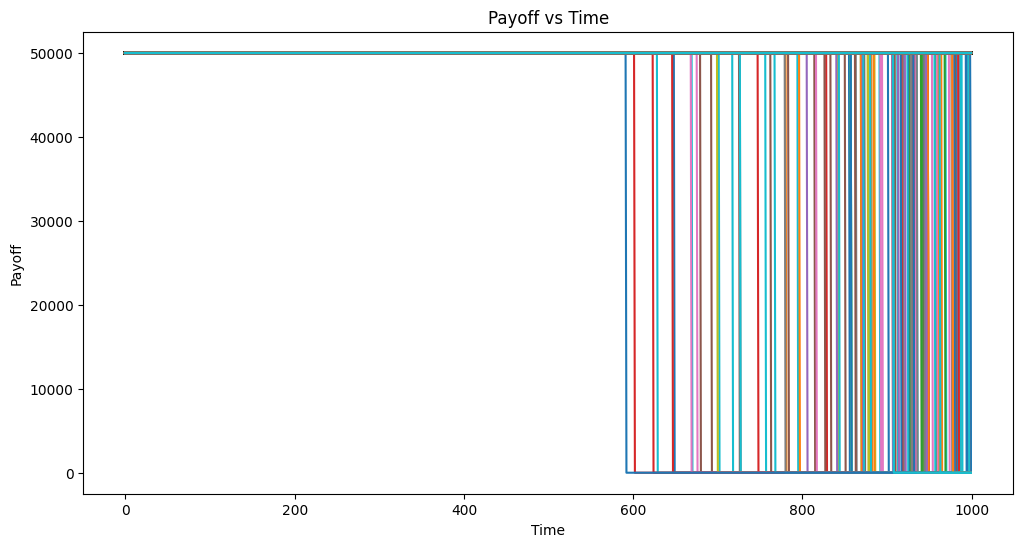

In [61]:
plt.figure(figsize=(12, 6))
for _, movement in enumerate(sim):
    plt.plot(movement, label=f'Movement {movement}')
plt.xlabel('Time')
plt.ylabel('Payoff')

plt.title('Payoff vs Time')

plt.show()